# Modeling the Offer Response

## Introduction

Starbucks engages customers by sending them various offers regularly. How do we know which demographic groups respond best to which offer type? In the simulated dataset, we have 10 different offers and with varying level of responses. Our task is to combine transaction, demographic and offer data to train a binary classifier to predict whether or not an customer will respond to an offer.

From the project introduction, we know that the `offer completed` is not necessarily an accurate indicator on whether a customer responds to an offer because customer can "complete" offer without receiving nor viewing offer. The data preprocessing and cleaning present a great challenge. After analyzing existing data, here are the two sceniaros that an offer is considered as respondended:

- For an information offer, it is reviewed and purcahse is made during offer period. 
- For a discount or bogo offer, it is considered as responded if there are "offer completed" events and purchase made during the offer period. 

The offer period starts when a customer receives an offer and ends when it duration expires, i.e. offer period equals the offer receiving time plus its duration. In the case that the same offer has been sent to the customer, the offer starts with the first time when customer recieves it and ends when the last offer expires. 

The predictive modeling is based on algorithm and support from sklearn. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import time

import inspect as i

# Add pipelines to path for python modules
import sys; sys.path.insert(0, '../pipelines')

import data_processing.util as util
import data_processing.offer_response as dpofferresp
import offer_response.features as offerfe
import offer_response.model as offerm

# Input Datasets

The feature dataset will be built from 3 previously processed databsets. Here are the quick look of them. 

In [3]:
# portfolio
portfolio_df = util.load_pkl('../data/1_interim/portfolio.pkl')
portfolio_df.head()

,offer_reward,difficulty,duration,offer_id,web_ch,num_channels,email_ch,social_ch,mobile_ch,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,0,3,1,1,1,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,4,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,3,1,0,1,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,3,1,0,1,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,2,1,0,0,0,1,0


In [4]:
# profile
profile_df = util.load_pkl('../data/1_interim/profile.pkl')
profile_df.drop('became_member_on', axis=1, inplace=True)
profile_df.head()

,gender,age,customer_id,income,became_member_year,became_member_month,membership_length,became_member_year_2013,became_member_year_2014,became_member_year_2015,...,income_40K,income_50K,income_60K,income_70K,income_80K,income_90K,income_100K,income_110K,income_120K,income_130K
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,1513,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,1580,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,1228,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,1304,0,0,0,...,0,1,0,0,0,0,0,0,0,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,1394,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [5]:
profile_df.columns

Index(['gender', 'age', 'customer_id', 'income', 'became_member_year',
       'became_member_month', 'membership_length', 'became_member_year_2013',
       'became_member_year_2014', 'became_member_year_2015',
       'became_member_year_2016', 'became_member_year_2017',
       'became_member_year_2018', 'became_member_month_1',
       'became_member_month_2', 'became_member_month_3',
       'became_member_month_4', 'became_member_month_5',
       'became_member_month_6', 'became_member_month_7',
       'became_member_month_8', 'became_member_month_9',
       'became_member_month_10', 'became_member_month_11',
       'became_member_month_12', 'F', 'M', 'O', 'age_10s', 'age_20s',
       'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s',
       'age_90s', 'age_100s', 'income_30K', 'income_40K', 'income_50K',
       'income_60K', 'income_70K', 'income_80K', 'income_90K', 'income_100K',
       'income_110K', 'income_120K', 'income_130K'],
      dtype='object')

In [6]:
# transcript
transcript_df = util.load_pkl('../data/1_interim/transcript.pkl')
transcript_df.head()

,customer_id,event,time,offer_id,reward,amount,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,0,1,0,0


## Feature extraction

Even though the transcript dataset contains info for offers and transactions that the customer made, it is not organized by customer and offer thus not directly usable. In addtion, we'll need create labels for modeling, i.e. a column of **responded**. for a combination of a customer and an offer. To do that, we'll  need to extract purchase made during the offer period. If we look at this from software development perspective, these are really three domain entities; customers, offers and transctions. To separate "offers" and "transctions" in transcript data, we can rely on the `event` column. If the value of event is 'offer received', 'offer viewed' or 'offer completed', it belongs to offers dataset, otherwise, it goes to transctions. The percentage of these events are following:

In [7]:
# the percentage of unique events in transcript
round((transcript_df['event'].value_counts()/transcript_df.shape[0])*100,2)

transaction        45.33
offer received     24.88
offer viewed       18.83
offer completed    10.95
Name: event, dtype: float64

The **transactions** are asscoiated with customers i.e. doesn't have offer id. The general stragety is to extract the customer ids in the offers dataset, iterate offers by a customer to process transactions.  Cacluating the offer period then use it to filter the transctions associated to determine whether an offer is responded. The feature extraction logic is implemented in data_processing.offer_response **combine** method. 

In [8]:
sys.stdout.write(i.getsource(dpofferresp.combine))

def combine(portfolio_df, profile_df, transcript_df):
    """Create a combined dataframe from the transaction, demographic and offer data:
    
    Args:
        portfolio_df - a preprocessed panda dataframe contains offer metadata
        profile_df - a preprocessed panda dataframe contains customer demographic data
        transcript_df - a preprocessed panda dataframe contains transcript data
        
    Returns:
        combined_df - (dataframe),combined data from transaction, demographic and offer data
        
    """

    offers_df, transactions_df = dptrans.separate_offers_transactions(
        transcript_df)

    # aggregate transcript data by customer and offer
    aggd_df = dptrans.agg_offer_events(offers_df)
    print(f'aggd_df shape:{aggd_df.shape}')

    # add offer meta info to aggd
    combined_df = pd.merge(aggd_df, portfolio_df, on='offer_id', how='left')

    # capture customer's responses offers
    offer_response = []
    # transaction made within offer valid peri

2306

#### Combined Offer Response dataset

The output from feature extraction was persisted into offer_response.pkl file. Loading it back, 

In [9]:
offer_response_df = util.load_pkl('../data/1_interim/offer_response.pkl')
offer_response_df.shape

(63288, 68)

In [10]:
offer_response_df.head()

,customer_id,offer_id,offer_received_sum,offer_viewed_sum,offer_completed_sum,offer_reward,difficulty,duration,web_ch,num_channels,...,income_40K,income_50K,income_60K,income_70K,income_80K,income_90K,income_100K,income_110K,income_120K,income_130K
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,0,1,2,10,168,1,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,1,0,0,0,96,1,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,1,0,0,0,72,0,3,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,5,5,120,1,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,2,10,240,1,4,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Offer summary dataset
As parf of processing, we also produced a offer summary dataset. 

In [11]:
response_summary_df = util.load_pkl('../data/1_interim/offer_summary.pkl')
response_summary_df

,offer_id,count,responded_count,success_rate,offer_type
9,fafdcd668e3743c1bb461111dcafc2a4,6332,4433,70.01,discount
1,2298d6c36e964ae4a3e7e9706d1fb8c2,6325,4313,68.19,discount
5,5a8bc65990b245e5a138643cd4eb9837,6320,4002,63.32,informational
8,f19421c1d4aa40978ebb69ca19b0e20d,6262,3655,58.37,bogo
4,4d5c57ea9a6940dd891ad53e9dbe8da0,6330,2825,44.63,bogo
7,ae264e3637204a6fb9bb56bc8210ddfd,6374,2843,44.60,bogo
3,3f207df678b143eea3cee63160fa8bed,6331,2618,41.35,informational
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,6355,2504,39.40,bogo
2,2906b810c7d4411798c6938adc9daaa5,6285,2415,38.42,discount
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,6374,1472,23.09,discount


Text(0, 0.5, 'Success rate')

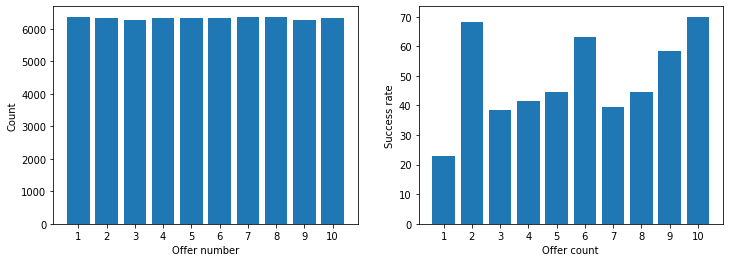

In [12]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

# the count of offers send to customer
ax[0].bar(response_summary_df.index + 1, response_summary_df['count'])
ax[0].set_xticks(np.arange(0,10) + 1)
ax[0].set_xlabel('Offer number')
ax[0].set_ylabel('Count')

# the respond rate by offer
ax[1].bar(response_summary_df.index + 1, response_summary_df['success_rate'])
ax[1].set_xticks(np.arange(0,10) + 1)
ax[1].set_xlabel('Offer count')
ax[1].set_ylabel('Success rate')

From the results shown above, we notice that the number of offers sent to customers is almost identical. Based on the rate that customers responded, two of the discount offer number **10** and **2** are the most responded with success rates 70% and 68%. The least responded offer is number 4 with rate 23%.

## Build models

### Final Feature selection

Currently offer_response dataset has 68 columns, and not all of them are useful set of columns from offer_response. 

In [13]:
len(offer_response_df.columns), offer_response_df.columns

(68,
 Index(['customer_id', 'offer_id', 'offer_received_sum', 'offer_viewed_sum',
        'offer_completed_sum', 'offer_reward', 'difficulty', 'duration',
        'web_ch', 'num_channels', 'email_ch', 'social_ch', 'mobile_ch', 'bogo',
        'discount', 'informational', 'responded', 'purchase_during_offer',
        'gender', 'age', 'became_member_on', 'income', 'became_member_on',
        'became_member_year', 'became_member_month', 'membership_length',
        'became_member_year_2013', 'became_member_year_2014',
        'became_member_year_2015', 'became_member_year_2016',
        'became_member_year_2017', 'became_member_year_2018',
        'became_member_month_1', 'became_member_month_2',
        'became_member_month_3', 'became_member_month_4',
        'became_member_month_5', 'became_member_month_6',
        'became_member_month_7', 'became_member_month_8',
        'became_member_month_9', 'became_member_month_10',
        'became_member_month_11', 'became_member_month_12', 'F',

**Dropping unneeded features**

We're going to drop following columns. These columns are either ids or the columns we have one-hot encoded.

In [14]:
cols_removal = [
    'customer_id',
    'offer_id',
    'offer_received_sum',
    'offer_viewed_sum',
    'offer_completed_sum',
    'age',
    'became_member_on',
    'became_member_year',
    'became_member_month',
    'income',
    'gender',
]

In [15]:
feature_df = offerfe.clean(offer_response_df, cols_removal=cols_removal)
feature_df.shape, feature_df.columns

((55222, 56),
 Index(['offer_reward', 'difficulty', 'duration', 'web_ch', 'num_channels',
        'email_ch', 'social_ch', 'mobile_ch', 'bogo', 'discount',
        'informational', 'responded', 'purchase_during_offer',
        'membership_length', 'became_member_year_2013',
        'became_member_year_2014', 'became_member_year_2015',
        'became_member_year_2016', 'became_member_year_2017',
        'became_member_year_2018', 'became_member_month_1',
        'became_member_month_2', 'became_member_month_3',
        'became_member_month_4', 'became_member_month_5',
        'became_member_month_6', 'became_member_month_7',
        'became_member_month_8', 'became_member_month_9',
        'became_member_month_10', 'became_member_month_11',
        'became_member_month_12', 'F', 'M', 'O', 'age_10s', 'age_20s',
        'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s',
        'age_90s', 'age_100s', 'income_30K', 'income_40K', 'income_50K',
        'income_60K', 'income_7

The final feature dataset has ~55k samples with 55 columns.

### Create train and test datasets

Column `responded` is our label column, the rest goes to as input. We are going split data into .7 for training and .3 for test. To minimize the impact of large numbers, we are going to apply MaxScaler for following colummns 

 - 'difficulty', 'duration', 'offer_reward', 'membership_length' and 'purchase_during_offer'
 
Combine things together ...

In [16]:
features_to_scale = ['difficulty', 'duration', 'offer_reward', 'membership_length', 'purchase_during_offer']

In [17]:
X_train, X_test, y_train, y_test = offerfe.create_training_data(offer_response_df, label_col='responded', test_size=0.3, cols_removal=cols_removal , features_to_scale=features_to_scale)

In [18]:
X_train.head()

,web_ch,num_channels,email_ch,social_ch,mobile_ch,bogo,discount,informational,became_member_year_2013,became_member_year_2014,...,income_90K,income_100K,income_110K,income_120K,income_130K,difficulty,duration,offer_reward,membership_length,purchase_during_offer
722,0,3,1,1,1,0,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.102578,0.054901
2362,1,3,1,0,1,0,0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.142857,0.0,0.229292,0.000000
13558,1,4,1,1,1,0,1,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.35,0.571429,0.3,0.066923,0.000000
35556,1,3,1,0,1,1,0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.571429,0.5,0.160176,0.035751
47193,1,4,1,1,1,0,1,0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.35,0.571429,0.3,0.896873,0.013843


**Check whether we have any large numbers**

In [19]:
max([X_train[c].max() for c in X_train.columns])

4

We don't have large numbers.

**Check whether the label data are balanced**

In [20]:
offerfe.check_label_balance(y_train, threshold=10)

value stats:
1    52.94
0    47.06
Name: responded, dtype: float64

Values std: 2.9399999999999977, threshod: 10.
Values for responded is balanced.


In [21]:
offerfe.check_label_balance(y_test, threshold=10)

value stats:
1    53.33
0    46.67
Name: responded, dtype: float64

Values std: 3.3299999999999983, threshod: 10.
Values for responded is balanced.


The delta of values (0, 1) in training and test label sets are within 3%, we can conclude that our training/testing dataset is nearly balanced. 

### Training

#### Model evaluation metrics

The training dataset is well balanced in terms of distribution of of labels. Evalaution metrics like precision, recall, and f1-score are good to use. 
- precision answers: what portion of postive identificaiton was actually correct?
- recall answers: what portion of active postive was identified correctly?
- F1-score represents "the harmonic mean of the precision and recall metrics".

In our training, we premarily focus on using f1-score.

#### Choice of Classifers

There are many different type of classifers that we can choose from sklearn. We are going to try out three: RandomForestClassifier, GradientBoostingClassifier and AdaBoostClassifier and compare their performance.

In [22]:
offerm.CLASSIFER_LIST

[RandomForestClassifier(random_state=42),
 GradientBoostingClassifier(random_state=42),
 AdaBoostClassifier(random_state=42)]

For the first path, we are just going through all classifers without any addtional tuning params to see how they fair.

In [23]:
clf_names = []
clf_f1_scores = []
clf_best_models = []
clf_time_taken = []

for clf in offerm.CLASSIFER_LIST:

    model, best_f1_score, time_taken = offerm.train(clf, {}, X_train, y_train, scoring='f1', cv=5, verbose=0)
    clf_names.append(clf.__class__.__name__)
    clf_f1_scores.append(best_f1_score)
    clf_best_models.append(model)
    clf_time_taken.append(time_taken)
    
result_dict = {'best_f1_score': clf_f1_scores,  'time_taken(s)': clf_time_taken, "best_model": clf_best_models}
result_df = pd.DataFrame(result_dict, index=clf_names)
result_df

Training RandomForestClassifier :
Time taken : 7.9 secs.
Best f1_score : 1.0
****************************************
Training GradientBoostingClassifier :
Time taken : 17.43 secs.
Best f1_score : 1.0
****************************************
Training AdaBoostClassifier :
Time taken : 0.24 secs.
Best f1_score : 1.0
****************************************


,best_f1_score,time_taken(s),best_model
RandomForestClassifier,1.0,7.90,"(DecisionTreeClassifier(max_features='auto', r..."
GradientBoostingClassifier,1.0,17.43,([DecisionTreeRegressor(criterion='friedman_ms...
AdaBoostClassifier,1.0,0.24,"(DecisionTreeClassifier(max_depth=1, random_st..."


All three classifers were achiving almost perfect f1_score(approx. 1.0) on its training dataset. How is this possible, we are going to explore this shortly. 

#### Model evaluation - Confusion Matrix

Since all three classifier have almost identical performance. We're going to look at the confusion matrix from RandomForestClassifier since it takes the shortest time to train.

In [24]:
randomforest_clf = clf_best_models[0]
randomforest_clf.__class__.__name__

'RandomForestClassifier'

In [25]:
y_pred = randomforest_clf.predict(X_test)
conf_matrix = offerm.get_confusion_matrix(y_test, y_pred, normalized=True)

true postives: 8834, false postives: 0
true negatives: 7731, false negatives: 2

Normalized confusion matrix:
[[1.00000000e+00 0.00000000e+00]
 [2.26346763e-04 9.99773653e-01]]


Even for the test dataset, the score was perfect!

#### Understand the model performance

A nearly perfect score is definitely delightful however worrysome. We're going to look at what contributes to this good score by looking at the feature importance!

In [26]:
feature_importance = offerm.calc_feature_importance(randomforest_clf, X_test.columns)
feature_importance[:10]

,feature,imp_perc
0,purchase_during_offer,80.70
1,membership_length,4.29
2,social_ch,2.15
3,num_channels,1.25
4,became_member_year_2018,1.23
5,difficulty,0.83
6,became_member_year_2016,0.61
7,offer_reward,0.60
8,duration,0.56
9,mobile_ch,0.52


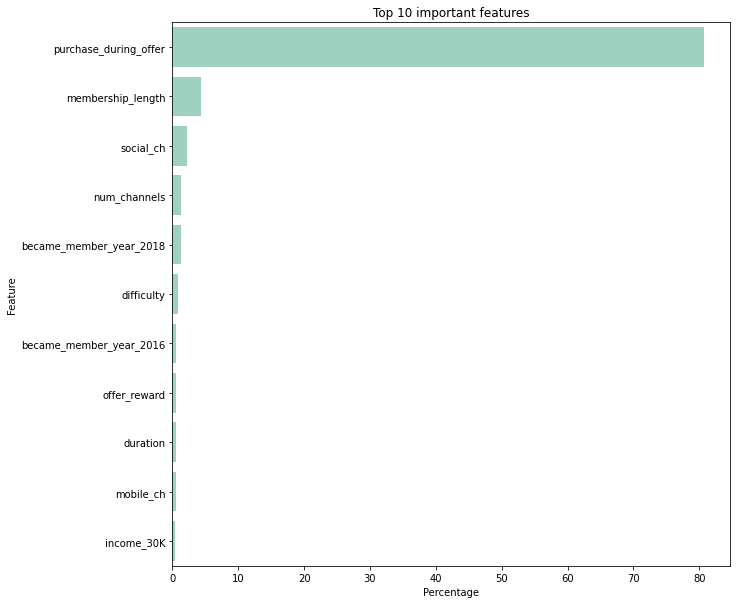

In [27]:
import offer_response.visualize as orvis
orvis.plot_feature_importance(feature_importance)

From the results shown above we notice that the `purchase_during_offer` is the most dominiate feature. The second is the membership_length.  Other features have very little influence to the prediction. `purchase_during_offer` is a compound feature that we calculated based on the purchase that customer made during an offer period. If we know a purchase made, we know customer repsonded and vice versa. In this light, the classifer is trained via machine learning, however this is not quite a true `predictive` model. Next, we are going to look into building a model without the knowledge of `purchase_during_offer`.

### Training without knowing the purchase made
We're going to remove `purchase_during_offer` from our features and retrain the model. 

In [28]:
cols_removal = [
    'customer_id',
    'offer_id',
    'offer_received_sum',
    'offer_viewed_sum',
    'offer_completed_sum',
    'age',
    'became_member_on',
    'became_member_year',
    'became_member_month',
    'income',
    'gender',
    'purchase_during_offer',
]

features_to_scale = ['difficulty', 'duration', 'offer_reward', 'membership_length']

X_train, X_test, y_train, y_test = offerfe.create_training_data(offer_response_df, label_col='responded', test_size=0.3, cols_removal=cols_removal, features_to_scale=features_to_scale)

In [29]:
new_clf_names = []
new_clf_f1_scores = []
new_clf_best_models = []
new_clf_time_taken = []

for clf in offerm.CLASSIFER_LIST:

    model, best_f1_score, time_taken = offerm.train(clf, {}, X_train, y_train, scoring='f1', cv=5, verbose=0)
    new_clf_names.append(clf.__class__.__name__)
    new_clf_f1_scores.append(best_f1_score)
    new_clf_best_models.append(model)
    new_clf_time_taken.append(time_taken)

Training RandomForestClassifier :
Time taken : 17.61 secs.
Best f1_score : 0.6703
****************************************
Training GradientBoostingClassifier :
Time taken : 24.12 secs.
Best f1_score : 0.7098
****************************************
Training AdaBoostClassifier :
Time taken : 8.98 secs.
Best f1_score : 0.7003
****************************************


In [30]:
new_result_dict = {'best_f1_score': new_clf_f1_scores,  'time_taken(s)': new_clf_time_taken, "best_model": new_clf_best_models}
new_result_df = pd.DataFrame(new_result_dict, index=new_clf_names)
new_result_df

,best_f1_score,time_taken(s),best_model
RandomForestClassifier,0.670284,17.61,"(DecisionTreeClassifier(max_features='auto', r..."
GradientBoostingClassifier,0.709751,24.12,([DecisionTreeRegressor(criterion='friedman_ms...
AdaBoostClassifier,0.700313,8.98,"(DecisionTreeClassifier(max_depth=1, random_st..."


The f1 score for all three classifer is lower but all still reasonable. For all 3, GradientBoostingClassifier has the best performance. 

**Confusion Matrix**

In [31]:
gb_clf = new_clf_best_models[1]
# randomforest_clf.__class__.__name__
y_pred = gb_clf.predict(X_test)
conf_matrix = offerm.get_confusion_matrix(y_test, y_pred, normalized=True)

true postives: 6255, false postives: 2507
true negatives: 5224, false negatives: 2581

Normalized confusion matrix:
[[0.67572112 0.32427888]
 [0.2921005  0.7078995 ]]


The results shows our model is able to identify 71% of cases that customer responded to an offer, 62% of cases that customer didn't respond to an offer. False Negatives is less than False positives, this means that Starbucks would less likely to miss sending offers to individuals who can respond and would still in balance of not sending offers to customers who would not respond.

**Feature importance**

We are going to look into feature importance output from GradientBoostingClassifier.

In [32]:
feature_importance = offerm.calc_feature_importance(gb_clf, X_test.columns)
feature_importance[:10]

,feature,imp_perc
0,membership_length,34.29
1,social_ch,23.46
2,offer_reward,7.60
3,num_channels,6.75
4,duration,5.30
5,discount,4.10
6,M,3.57
7,income_40K,3.21
8,income_30K,2.90
9,difficulty,2.54


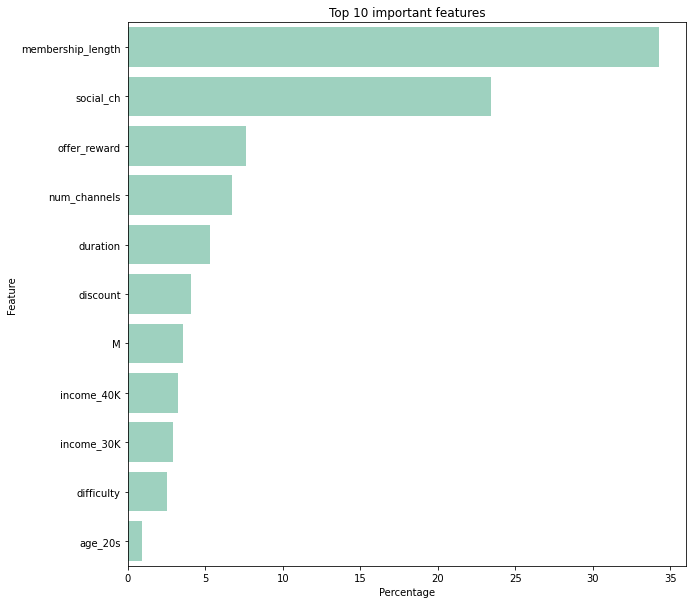

In [33]:
orvis.plot_feature_importance(feature_importance)

Inferring from the top 10 features, the factors that influence the customer's response to an offer, 
    
- Number one, the length of the membership. The longer of being a member, it is more likely for she/he to respond. This intuitively makes sense.
- Offer broadcasted via 'social' channel is ranked as the second. This also makes sense due to greater media exposure.  
- num_channels is calculated and indicates the number of channels that the offer is visible. The higher number of channels, the more likely customers will see it and respond.
- Multiple age groups, 'age_40s', 'age_50s', 'age_60s' and 'age_70s' are on the list. This indicates age of the customer should be carefully looked at when sending an offer.    
- 'income_70ths' feature, which represents if customer's income is in bucket of 70k to 80K. This may be a significant group for engagement. 

### Hyperparameter Tuning

We are going to useing GridSearch to look for best GradientBoostingClassifier with following set of parameters. 

**n_estimators**

n_estimators represents the number of trees in the forest. Usually the larger the number, the bette model learns the data. However, adding a lot of estimators can slow down the training process considerably without benefit of performance.

In [34]:
def get_f1_score(grid, param_name):
    """Get f1_score from GridSearchCV 
    
    Args:
        a fitted grid
        
    Returns:
        None
    """
                                             
    clf = grid.best_estimator_
    y_pred = clf.predict(X_test)
    test_f1_score = f1_score(y_test, y_pred)
    print(f'Grid search result: best {param_name} = {grid.best_params_}, best training_score = {grid.best_score_}, f1_score: {test_f1_score}')

In [35]:
def get_scores(param_name):
    """Get test scores from GridSearchCV
    Args:
        hyperparam_key: name of the hyperparameter from GridSearchCV cv_results_
        
    Returns:
        A panda dataframe with test scores.
    
    """
    cols = [f'param_{param_name}', 'mean_test_score', 'std_test_score']
    result_df = pd.DataFrame(columns=cols)
    for col in cols:
        result_df[col] = grid.cv_results_[col]
    return result_df    

In [36]:
params = {'n_estimators':range(4,33,4)}
grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, random_state=42), param_grid = params, scoring='f1',n_jobs=4, cv=5, return_train_score=True)  
grid.fit(X_train,y_train);

In [37]:
param_name = list(params.keys())[0]
get_f1_score(grid, param_name)
get_scores('n_estimators')

Grid search result: best n_estimators = {'n_estimators': 28}, best training_score = 0.7182956315413115, f1_score: 0.7199444058373871


,param_n_estimators,mean_test_score,std_test_score
0,4,0.692321,0.000000
1,8,0.692321,0.000000
2,12,0.703037,0.000505
3,16,0.712773,0.001534
4,20,0.712238,0.003582
5,24,0.715227,0.006476
6,28,0.718296,0.003929
7,32,0.715927,0.005731


n_estimators as 28 has the best score.

**max_depth**

max_depth represents the depth of each tree in the forest. The deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 32.

In [38]:
param_name = 'max_depth'
max_depths = range(5,16,2)
params = {param_name:max_depths}

grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, n_estimators=28, random_state=42), param_grid = params, scoring='f1',n_jobs=4, cv=5, return_train_score=True)  
grid.fit(X_train,y_train);

In [39]:
get_f1_score(grid, param_name)
get_scores(param_name)

Grid search result: best max_depth = {'max_depth': 7}, best training_score = 0.7269588475386956, f1_score: 0.7326290125965056


,param_max_depth,mean_test_score,std_test_score
0,5,0.720968,0.001518
1,7,0.726959,0.002143
2,9,0.722594,0.003338
3,11,0.716878,0.004319
4,13,0.708853,0.003207
5,15,0.701408,0.002438


Max_depth as 7 is the optimal value.

**min_samples_leaf**

min_samples_leaf is The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.

In [40]:
min_samples_leafs = range(10,31,5)
param_name = 'min_samples_leaf'
params = {param_name:min_samples_leafs}

grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, n_estimators=28, max_depth=7, random_state=42), param_grid = params, scoring='f1',n_jobs=4, cv=5, return_train_score=True)  
grid.fit(X_train,y_train);

In [41]:
get_f1_score(grid, param_name)
get_scores(param_name)

Grid search result: best min_samples_leaf = {'min_samples_leaf': 25}, best training_score = 0.7274949155769966, f1_score: 0.7327887981330221


,param_min_samples_leaf,mean_test_score,std_test_score
0,10,0.726926,0.001793
1,15,0.727335,0.002657
2,20,0.727284,0.002135
3,25,0.727495,0.001850
4,30,0.725879,0.002118


Optimal min_samples_leaf is 25. 

**max_features**

max_features represents the number of features to consider when looking for the best split.

In [42]:
max_features = list(range(1,X_train.shape[1], 4))
param_name = 'max_features'
params = {param_name:max_features}

grid = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.01, n_estimators=28, max_depth=7, min_samples_leaf=25, random_state=42), param_grid = params, scoring='f1',n_jobs=4, cv=5, return_train_score=True)  
grid.fit(X_train,y_train);

In [43]:
get_f1_score(grid, param_name)
get_scores(param_name)

Grid search result: best max_features = {'max_features': 45}, best training_score = 0.7284238685220747, f1_score: 0.7310365978327539


,param_max_features,mean_test_score,std_test_score
0,1,0.705190,0.001194
1,5,0.726174,0.003428
2,9,0.727890,0.003311
3,13,0.726425,0.001543
4,17,0.726398,0.001698
5,21,0.727720,0.001264
6,25,0.727444,0.002583
7,29,0.727796,0.001806
8,33,0.727929,0.002502
9,37,0.727600,0.002241


**Final model**

In [44]:
clf = grid.best_estimator_
clf

GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=45,
                           min_samples_leaf=25, n_estimators=28,
                           random_state=42)

In [45]:
y_pred = clf.predict(X_test)
conf_matrix = offerm.get_confusion_matrix(y_test, y_pred, normalized=True)

true postives: 7151, false postives: 3577
true negatives: 4154, false negatives: 1685

Normalized confusion matrix:
[[0.53731729 0.46268271]
 [0.19069715 0.80930285]]


In [46]:
offerm.save_model(clf, '../output/models/offer_response.pkl')

## Improvements

Addtional data and more accurate data may increase the performance of the model, specifically

1. Larger data collection for customer demographic info. In the current set, we only have age, gender, and income. The region where customer lives would be a nice to have.
  
2. Different way to collect data. With current dataset, the transactions are to have been inferred based on offer period. This reduces the accuracy of labeling the dataset.

3. Include `customer_id` as part of input features to improve model accuracy. Even though 'customer_id' is a str type, we can apply the Hashed Feature design pattern. More info about this design pattern can be found at [Machine Learning Design Patterns](https://learning.oreilly.com/library/view/machine-learning-design/9781098115777/ch02.html#problem-id00001). 

## Reference

 - [Complete Machine Learning Guide to Parameter Tuning in Gradient Boosting (GBM) in Python](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)
 - [In Depth: Parameter tuning for Random Forest](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d).